In [3]:
import os
import sys
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import pdb
from tqdm import tqdm
from rpy2.robjects.conversion import localconverter
from myclass.CleanMergeDataset import Clean_Merge_Dataset
from myclass.BonferroniTtest import Bonferroni_Ttest
#import plotly.express as px
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#reload(myclass.BonferroniTtest)
#reload(myclass.CleanMergeDataset)
from rpy2.robjects.packages import STAP
import rpy2.robjects as robjects

In [4]:

illu_n = pd.read_csv('BIOINFORMATICS/illumina-27-450-normal.csv')
illu_t = pd.read_csv('BIOINFORMATICS/illumina450-27-tumor.csv')
illu_1, illu_2 = Clean_Merge_Dataset().transform(illu_n, illu_t)
dataset_illumina, illu_l = Bonferroni_Ttest(alpha = 0.05, label_case_id_into_X=True).fit_transform(illu_1, illu_2)


rna_n = pd.read_csv('BIOINFORMATICS/RNA_dataframe_normal.csv')
rna_t = pd.read_csv('BIOINFORMATICS/RNA_dataframe.csv')
rna_1, rna_2 = Clean_Merge_Dataset().transform(rna_n, rna_t)
dataset_RNA, rna_l = Bonferroni_Ttest(alpha = 0.05, label_case_id_into_X=True).fit_transform(rna_1, rna_2)


mirna_n = pd.read_csv('BIOINFORMATICS/miRNA_dataframe_normal.csv')
mirna_t = pd.read_csv('BIOINFORMATICS/miRNA_dataframe.csv')
mirna_1, mirna_2 = Clean_Merge_Dataset().transform(mirna_n, mirna_t)
dataset_miRNA, mirna_l = Bonferroni_Ttest(alpha = 0.05, label_case_id_into_X=True).fit_transform(mirna_1, mirna_2)

dataset_RNA = dataset_RNA[dataset_RNA["label"] != "CPTAC-3"]
dataset_miRNA = dataset_miRNA[dataset_miRNA["label"] != "CPTAC-3"]
#dataset_illumina = dataset_illumina[dataset_illumina["label"] != "CPTAC-3"]


Data_normal: (125, 25982)
Data_tumor: (1082, 25982)
All data: (1207, 25982)
{'TCGA-LUAD', 'TCGA-LUSC'}
Features completly 0 values 0 removed
Features completely Nan 2597 removed
Final dataset shape (1206, 19698)
Final dataset shape: (1206, 15697)
Data_normal: (305, 60487)
Data_tumor: (1071, 60487)
All data: (1376, 60487)
{'TCGA-LUAD', 'TCGA-LUSC', 'CPTAC-3'}
Features completly 0 values 2057 removed
Features completely Nan 0 removed
Final dataset shape (1375, 58429)
Final dataset shape: (1375, 5554)
Data_normal: (136, 1885)
Data_tumor: (623, 1885)
All data: (759, 1885)
{'TCGA-LUAD', 'TCGA-LUSC', 'CPTAC-3'}
Features completly 0 values 240 removed
Features completely Nan 0 removed
Final dataset shape (759, 1644)
Final dataset shape: (759, 136)


##Preprocessing

In [5]:
def uniqueCaseID(data):
  
    new = {}
    new["case_id1"] = []
    data = data.sort_values(by=['case_id']).reset_index(drop=True)
    for i,row in data.iterrows():
        new["case_id1"].append(data.loc[i,"case_id"]+"_"+str(data.loc[i,'label']))
    
    new_df = pd.DataFrame(new, columns = ["case_id1"])
    conc_df = pd.concat([new_df,data], axis=1)
    conc_df = conc_df.drop(["case_id"], axis=1)
    
    return conc_df

print(dataset_illumina.shape)
print(dataset_illumina.isnull().sum().sum())
print(dataset_RNA.isnull().sum().sum())
print(dataset_miRNA.isnull().sum().sum())

illu = uniqueCaseID(dataset_illumina)
rna = uniqueCaseID(dataset_RNA)
mirna = uniqueCaseID(dataset_miRNA)

print(illu.isnull().sum().sum())
print(rna.isnull().sum().sum())
print(mirna.isnull().sum().sum())



i1 = set(illu['case_id1'])
i2 = set(mirna['case_id1'])
i3 = set(rna['case_id1'])

#Prendiamo i case_id_label che stanno in tutti e 3 le omiche
distinct_case_id = [x for x in i2 if x in i1 and x in i3]


#print(distinct_case_id)
#Filtriamo i case_id_label che non stanno in tutte e 3 le omiche
illu = illu.loc[illu['case_id1'].isin(distinct_case_id)]
rna = rna.loc[rna['case_id1'].isin(distinct_case_id)]
mirna = mirna.loc[mirna['case_id1'].isin(distinct_case_id)]

illu = illu.sort_values(by=['case_id1']).reset_index(drop=True)
rna = rna.sort_values(by=['case_id1']).reset_index(drop=True)
mirna = mirna.sort_values(by=['case_id1']).reset_index(drop=True)

#print(rna)
#print(mirna)
#print(illu)

print(illu.shape)
print(rna.shape)
print(mirna.shape)


label = illu['label']
label[label == False] ='False'

(1206, 15699)
0
0
0
0
0
0
(430, 15699)
(430, 5556)
(430, 138)


##Multiomics analisis

In [50]:


with localconverter(ro.default_converter + pandas2ri.converter):
  r_illu_d = ro.conversion.py2rpy(illu.drop(["case_id1","label"], axis=1))

with localconverter(ro.default_converter + pandas2ri.converter):
  r_miRNA_d = ro.conversion.py2rpy(mirna.drop(["case_id1","label"], axis=1))

with localconverter(ro.default_converter + pandas2ri.converter):
  r_rna_d = ro.conversion.py2rpy(rna.drop(["case_id1","label"], axis=1))

import rpy2.robjects as robjects
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage


##LRA cluster R
file_LRA_cluster = open("LRAcluster/R/LRAcluster.R",'r')

string_LRA_cluster = ''.join(file_LRA_cluster.readlines())

LRA_cluster = SignatureTranslatedAnonymousPackage(string_LRA_cluster, "LRAcluster")

#Trasformiamo in matrici i 3 dataset
matrix_r_miRNA_d = LRA_cluster.getMatrix(r_miRNA_d)
matrix_r_illu_d = LRA_cluster.getMatrix(r_illu_d)
matrix_r_rna_d = LRA_cluster.getMatrix(r_rna_d)

#Uniamo le matrici --> data
import time;

unionMatrix = LRA_cluster.unionMatrix3(matrix_r_illu_d, matrix_r_rna_d, matrix_r_miRNA_d)
start_time = time.time()
output_R = LRA_cluster.LRAcluster(unionMatrix,4)
print(start_time - time.time())
with localconverter(ro.default_converter + pandas2ri.converter):
    output = ro.conversion.rpy2py(output_R[0])

clustering = KMeans(n_clusters=3, max_iter=500).fit(output)
clustering1 = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(output)
clustering2 = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(output)


print("KMEANS")
print("silhuette: ", silhouette_score(output, clustering.labels_))
print("rand indexa: ", adjusted_rand_score(label, clustering.labels_))
print("AGGLOMERATIVE CLUSTERING")
print("silhuette: ", silhouette_score(output, clustering1.labels_))
print("rand indexa: ", adjusted_rand_score(label, clustering1.labels_))
print("SPECTRAL CLUSTERING")
print("silhuette: ", silhouette_score(output, clustering2.labels_))
print("rand indexa: ", adjusted_rand_score(label, clustering2.labels_))

-62.81789016723633
KMEANS
silhuette:  0.52362589721016
rand indexa:  0.6108130981229783
AGGLOMERATIVE CLUSTERING
silhuette:  0.47203082489677567
rand indexa:  0.6386068837947068
SPECTRAL CLUSTERING
silhuette:  0.6139339599537874
rand indexa:  0.7648398244854514


In [55]:
#LRA cluster python implementation
label = illu['label']
label[label == False] ='False'

from PyLRAcluster.LRACluster import LRAcluster

label[label == False] ='False'

illu_m = np.transpose(illu.drop(["case_id1","label"], axis=1).to_numpy())
rna_m = np.transpose(rna.drop(["case_id1","label"], axis=1).to_numpy())
mirna_m = np.transpose(mirna.drop(["case_id1","label"], axis=1).to_numpy())

start_time = time.time()
output,p = LRAcluster([illu_m,rna_m,mirna_m],['gaussian','poisson','poisson'],3)
print(start_time - time.time())
clustering = KMeans(n_clusters=3, max_iter=500).fit(output)
clustering1 = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(output)
clustering2 = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(output)


print("KMEANS")
print("silhuette: ", silhouette_score(output, clustering.labels_))
print("rand indexa: ", adjusted_rand_score(label, clustering.labels_))
print("AGGLOMERATIVE CLUSTERING")
print("silhuette: ", silhouette_score(output, clustering1.labels_))
print("rand indexa: ", adjusted_rand_score(label, clustering1.labels_))
print("SPECTRAL CLUSTERING")
print("silhuette: ", silhouette_score(output, clustering2.labels_))
print("rand indexa: ", adjusted_rand_score(label, clustering2.labels_))



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
-18.98599600791931
KMEANS
silhuette:  0.5763273
rand indexa:  0.6069320081470351
AGGLOMERATIVE CLUSTERING
silhuette:  0.5257102
rand indexa:  0.6336310471108969
SPECTRAL CLUSTERING
silhuette:  0.6268071
rand indexa:  0.7729595367847442


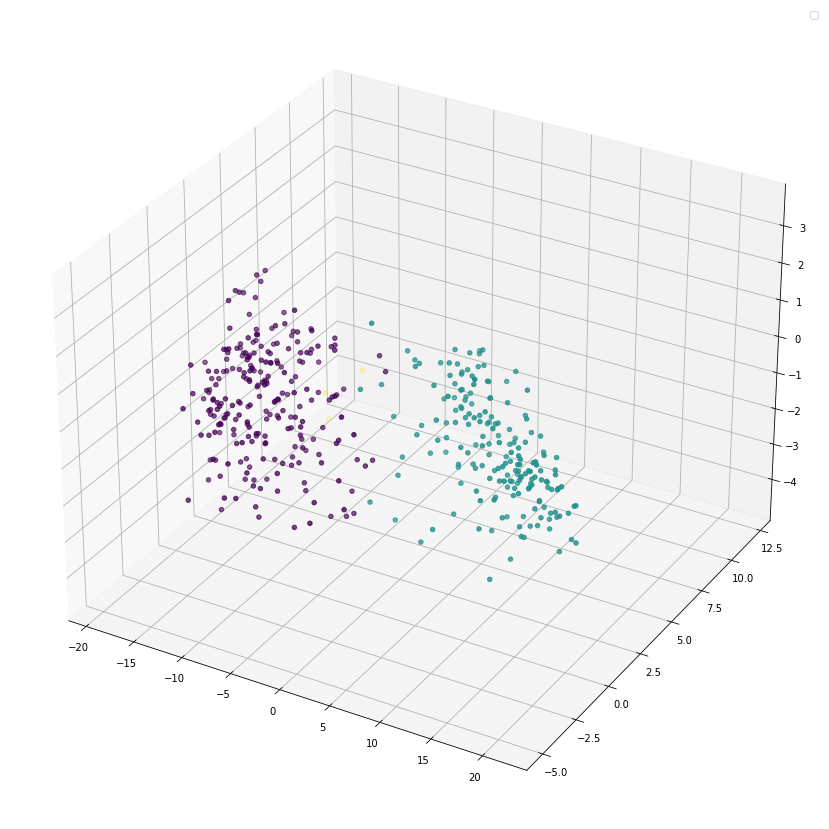

In [65]:
##Plot graph##
le = LabelEncoder()
labels_num = le.fit_transform(clustering2.labels_)
plt.figure('LRA 3 dimension Spectral clustering', figsize=(15,15))
ax = plt.axes(projection = '3d')
ax.legend()
ax.scatter(output[:,0],output[:,1],output[:,2],c=labels_num);

In [57]:

# DATI CLINICI
import os
import json
import pandas as pd
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go

"""
    Class to extract the clinical_case from the json file.
    It returns a dataframe in the following form:
    case_id| ...[clinical case]...| label.
"""
#Spectral clustering
y_pred = clustering2.labels_

class ExtractClinicalCase:
    def __init__(self, cases_id):
        with open('dati_clinici.json', 'r') as json_file:
            data = json.load(json_file)

        remove_el = list()
        for el in data:
            if el['case_id'] not in cases_id:
                remove_el.append(el)

        for el in remove_el:
            data.remove(el)
        
        clinical_data = {'case_id': '',
                        'tumor_stage': '',
                        'prior_malignancy': '',
                        'age_at_diagnosis': None,
                        'morphology': '',
                        'label': ''}

        self.df = pd.DataFrame(data=[], columns=clinical_data.keys())

        for i, el in enumerate(data):
            clinical_data['case_id'] = el['case_id']
            clinical_data['tumor_stage'] = el['diagnoses'][0]['tumor_stage']
            clinical_data['prior_malignancy'] = el['diagnoses'][0]['prior_malignancy']
            if el['diagnoses'][0]['age_at_diagnosis'] is not None:
                value = int(el['diagnoses'][0]['age_at_diagnosis'])/365
                clinical_data['age_at_diagnosis'] = self.__truncate__(value)

            clinical_data['morphology'] = el['diagnoses'][0]['morphology']

            self.df = self.df.append(pd.DataFrame(clinical_data, index=[i]), ignore_index=True)
        
    def get_df_clinical_case(self):
        return self.df

    def __truncate__(self, n, decimals=-1):
        """
            Function to take the decade of the age.
        """
        multiplier = 10 ** decimals
        return int(n * multiplier) / multiplier
                


## PRIMA CREI IL DF 
cases_id = [el.split('_')[0] for el in rna['case_id1']]
#ExtractClinicalCase è una mia classe per avere i clinical case dei case_id che abbiamo
df_clinical_case = ExtractClinicalCase(cases_id).get_df_clinical_case()

df_clinical_case.sort_values(by='case_id', inplace=True)
df = pd.DataFrame()
df['case_id'] = cases_id
df['label'] = y_pred
clinica_cases_id = [el.replace('\n', '') for el in df_clinical_case['case_id']]

label = df.loc[df['case_id'].isin(clinica_cases_id)]['label']
df_clinical_case['label'] = label


# POI USI LA FUNZIONE
def plot_clinical_data(df_clinical_case, name_clinical_field, title=''):
    dict_ = {}
    df = pd.DataFrame()
    df_clinical_case.dropna(inplace=True)

    # Consideriamo 
    for l in range(0, 3):
        dict_['Cluster'] = l
        for el in set(df_clinical_case[name_clinical_field]):
            el_cluster = df_clinical_case[df_clinical_case['label'] == l]
            count = el_cluster[el_cluster[name_clinical_field] == el]['case_id'].count()
            dict_[el] = count

        df = df.append(pd.DataFrame(dict_, index=[0]))

    fig = go.Figure()
    
    for key in df.columns[1:]:
        fig = fig.add_trace(
            go.Bar(name=key, x=df['Cluster'], y=df[key])
        )
    
    # Change the bar mode
    fig.update_layout(barmode='stack',
                      title=title,
                      xaxis_title="Clusters",
                      yaxis_title="Count")
    fig.show() 
    return

# ESEMPIO 
plot_clinical_data(df_clinical_case, 'prior_malignancy', 'Prior Malignancy Distribution')
plot_clinical_data(df_clinical_case, 'age_at_diagnosis', 'Age at diagnosis Distribution')
plot_clinical_data(df_clinical_case, 'tumor_stage', 'Tumor stage Distribution')
plot_clinical_data(df_clinical_case, 'morphology', 'Morphology Distribution')

In [66]:
#Clustering a singola omica
def vectorIndicator(indicator_vector_matrix,labels):
    new_encodings = []
    for i in range(labels.shape[0]):
        label_encoding = [0,0,0]
        label_encoding[labels[i]] = 1 # 0 -> [1,0,0] 1 ->[0,1,0] 2->[0,0,1]
        new_encodings.append(label_encoding)
    if indicator_vector_matrix.shape[0] == 0:
        indicator_vector_matrix = np.array(new_encodings)
    else:
        indicator_vector_matrix = np.concatenate((indicator_vector_matrix,np.array(new_encodings)),axis=1)
    return indicator_vector_matrix

def compute_vector_indicator(*args):
    indicator_vector_matrix = np.array([])
    for a in args:
        indicator_vector_matrix = vectorIndicator(indicator_vector_matrix,a.labels_)
    return indicator_vector_matrix

illu_r = illu.drop(['case_id1','label'],axis=1)
mirna_r = mirna.drop(['case_id1','label'],axis=1)
rna_r = rna.drop(['case_id1','label'],axis=1)
clustering_illu = KMeans(n_clusters=3, max_iter=500).fit(illu_r)
clustering1_illu = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(illu_r)
clustering2_illu = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(illu_r)

clustering_mirna = KMeans(n_clusters=3, max_iter=500).fit(mirna_r)
clustering1_mirna = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(mirna_r)
clustering2_mirna = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(mirna_r)

clustering_rna = KMeans(n_clusters=3, max_iter=500).fit(rna_r)
clustering1_rna = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(rna_r)
clustering2_rna = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(rna_r)

X = compute_vector_indicator(clustering_illu,clustering1_illu,clustering2_illu,
                                                    clustering_mirna,clustering1_mirna,clustering2_mirna
                                                    ,clustering_rna,clustering1_rna,clustering2_rna)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=3)
model = model.fit(X)
print("silhuette: ", silhouette_score(X_pca, model.labels_))
print("rand indexa: ", adjusted_rand_score(label, model.labels_))



silhuette:  0.15103665172887892
rand indexa:  0.516258611277649


In [30]:
y_pred = model.labels_
df_clinical_case = ExtractClinicalCase(cases_id).get_df_clinical_case()

df_clinical_case.sort_values(by='case_id', inplace=True)
df = pd.DataFrame()
df['case_id'] = cases_id
df['label'] = y_pred
clinica_cases_id = [el.replace('\n', '') for el in df_clinical_case['case_id']]

label = df.loc[df['case_id'].isin(clinica_cases_id)]['label']
df_clinical_case['label'] = label

plot_clinical_data(df_clinical_case, 'prior_malignancy', 'Prior Malignancy Distribution')
plot_clinical_data(df_clinical_case, 'age_at_diagnosis', 'Age at diagnosis Distribution')
plot_clinical_data(df_clinical_case, 'tumor_stage', 'Tumor stage Distribution')
plot_clinical_data(df_clinical_case, 'morphology', 'Morphology Distribution')